<a href="https://colab.research.google.com/github/MathieuFan22/Mirada-Examen-ML-M2-ISPM/blob/Mathieu/PoketraFinday-Mirada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

df = pd.read_csv('/content/train.csv')
display(df.head())
print("\nDataFrame Info:")
df.info()

print("\nDescriptive Statistics:")
display(df.describe())

First 5 rows of the DataFrame:


,transaction_id,step,type,amount,customer_id,age,is_fraud
0,38d8cd1a-ab64-48a8-982b-547db096f8a5,421,PAYMENT,311000,C13646530,24,0
1,2440928e-8a4c-4e74-a9c5-6329668be13d,325,PAYMENT,399600,C9452763,25,0
2,973c2a3c-5676-477c-ac30-81334b01e90d,565,PAYMENT,7500,C31260354,38,0
3,5413d0f4-b4f0-406f-bd91-91de1dce573c,511,TRANSFER,94000,C8841991,26,0
4,c9fa99e2-42c8-4dd8-94ba-aa3e44bfdd98,63,CASH_OUT,15000,C3176716,26,0



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  30000 non-null  object
 1   step            30000 non-null  int64 
 2   type            30000 non-null  object
 3   amount          30000 non-null  int64 
 4   customer_id     30000 non-null  object
 5   age             30000 non-null  int64 
 6   is_fraud        30000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.6+ MB

Descriptive Statistics:


,step,amount,age,is_fraud
count,30000.000000,3.000000e+04,30000.000000,30000.000000
mean,361.139733,1.474855e+05,34.516800,0.019833
std,207.894173,4.114664e+05,16.067294,0.139430
min,0.000000,1.000000e+02,18.000000,0.000000
25%,180.000000,1.750000e+04,23.000000,0.000000
50%,364.000000,4.930000e+04,28.000000,0.000000
75%,541.000000,1.360000e+05,43.000000,0.000000
max,719.000000,1.921400e+07,90.000000,1.000000


## Analyze Target Variable Distribution



In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Distribution of 'is_fraud' column:")
fraud_counts = df['is_fraud'].value_counts()
print(fraud_counts)



Distribution of 'is_fraud' column:
is_fraud
0    29405
1      595
Name: count, dtype: int64


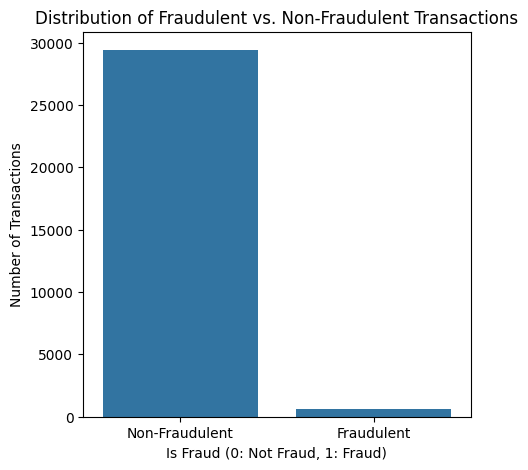

In [15]:
plt.figure(figsize=(5, 5))
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

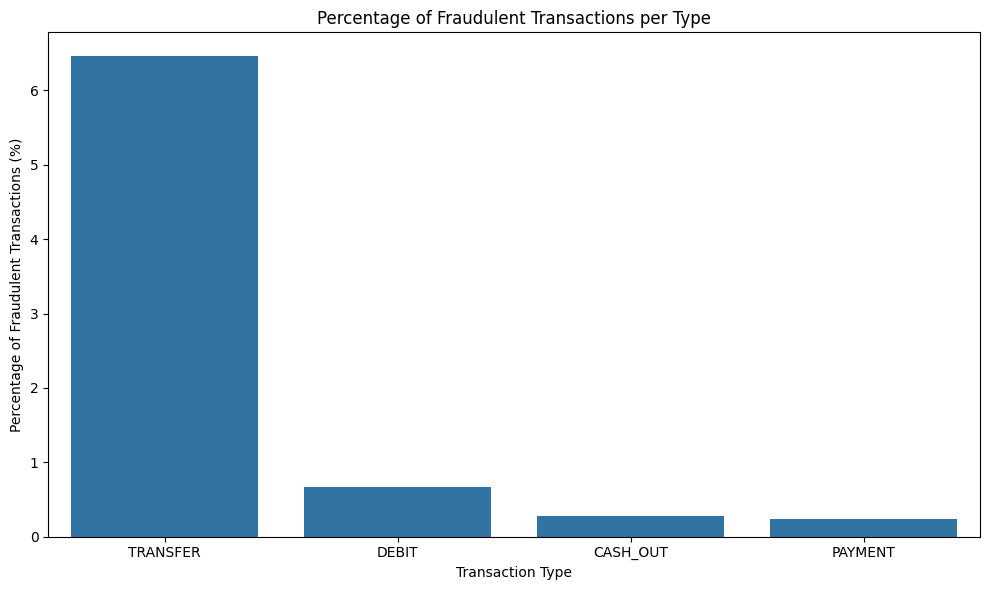

In [25]:
# # Calculate counts of fraudulent transactions for each type
fraud_type_counts = df[df['is_fraud'] == 1]['type'].value_counts()
# print("\nFraudulent transaction counts by type:")
# display(fraud_type_counts)

## Calculate total transactions for each type
total_type_counts = df['type'].value_counts()
# print("\nTotal transaction counts by type:")
# display(total_type_counts)

# # Calculate percentage of fraudulent transactions for each type
fraud_percentage_by_type = (fraud_type_counts / total_type_counts * 100).fillna(0).sort_values(ascending=False)
# print("\nPercentage of fraudulent transactions by type:")
# display(fraud_percentage_by_type)

# # Plotting the counts of fraudulent transactions by type
# plt.figure(figsize=(10, 6))
# sns.barplot(x=fraud_type_counts.index, y=fraud_type_counts.values, palette='viridis')
# plt.title('Number of Fraudulent Transactions per Type')
# plt.xlabel('Transaction Type')
# plt.ylabel('Number of Fraudulent Transactions')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Plotting the percentage of fraudulent transactions by type
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_percentage_by_type.index, y=fraud_percentage_by_type.values)
plt.title('Percentage of Fraudulent Transactions per Type')
plt.xlabel('Transaction Type')
plt.ylabel('Percentage of Fraudulent Transactions (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Explore Numerical Features vs. `is_fraud`

### Step:



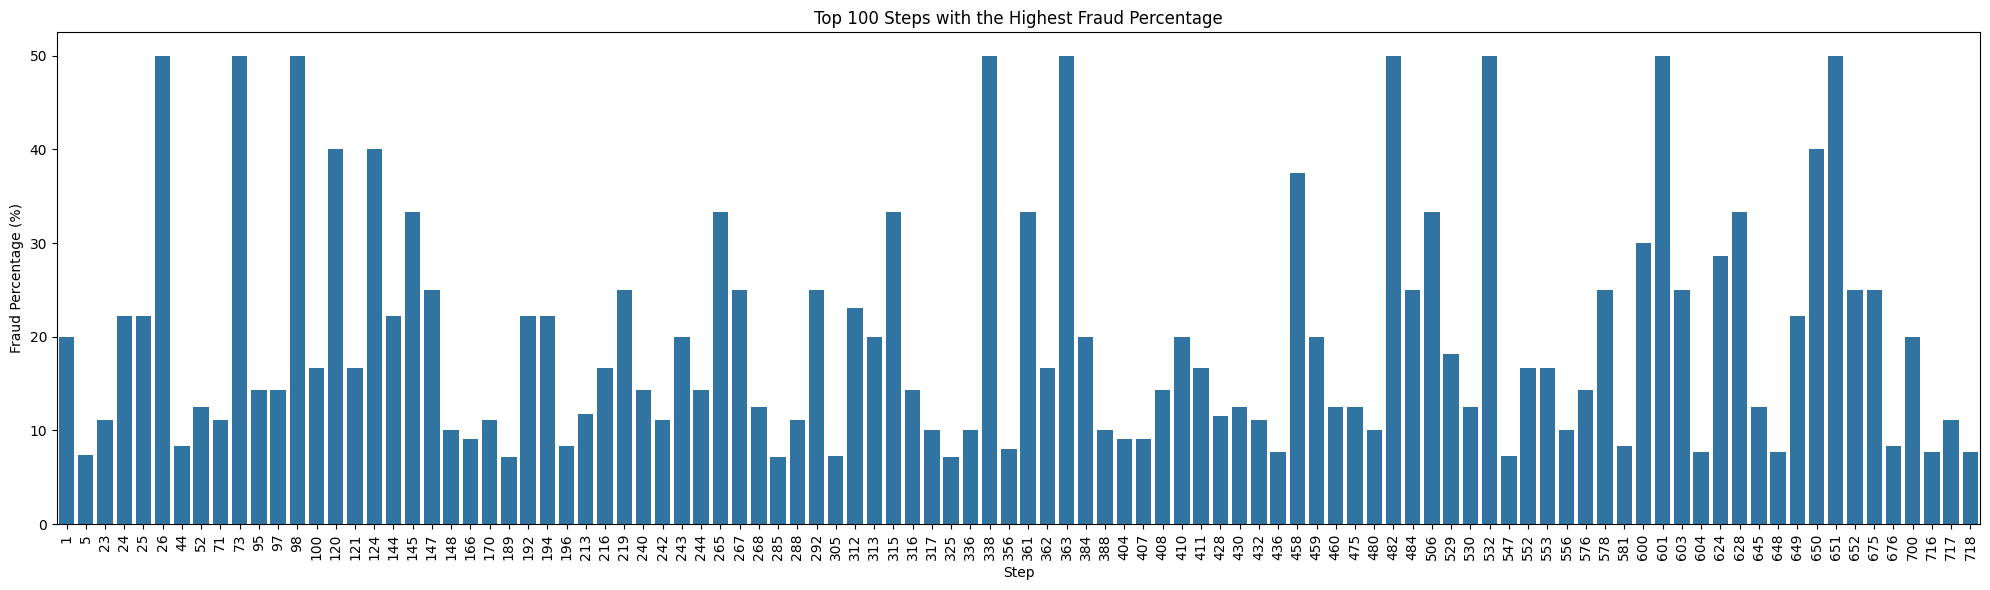

In [37]:
# Count fraudulent transactions per step
fraud_step_counts = df[df['is_fraud'] == 1]['step'].value_counts()

# Count total transactions per step
total_step_counts = df['step'].value_counts()

# Calculate percentage
fraud_percentage_by_step = (
    fraud_step_counts / total_step_counts * 100
).fillna(0).sort_values(ascending=False)
top_n = 100
top_fraud_steps = fraud_percentage_by_step.head(top_n)

# Colors to avoid the Seaborn warning
colors = sns.color_palette("plasma", len(top_fraud_steps))

plt.figure(figsize=(20, 6))
sns.barplot(
    x=top_fraud_steps.index,
    y=top_fraud_steps.values
)

plt.title(f'Top {top_n} Steps with the Highest Fraud Percentage')
plt.xlabel('Step')
plt.ylabel('Fraud Percentage (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Correlation with 'is_fraud' column:


,is_fraud
is_fraud,1.000000
type_TRANSFER,0.196184
amount,0.117376
step,0.008655
age,-0.007045
type_DEBIT,-0.031188
type_PAYMENT,-0.096046


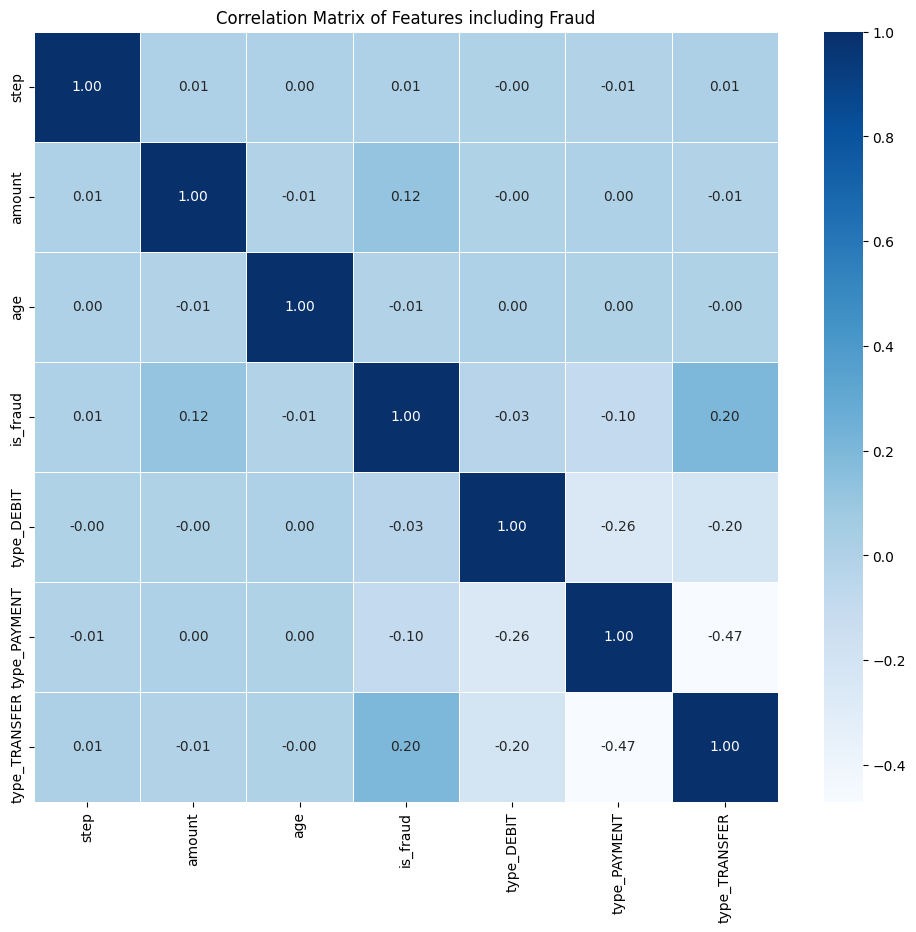

In [48]:

df_temp = df.copy()

columns_to_drop_if_present = ['transaction_id', 'customer_id']
for col in columns_to_drop_if_present:
    if col in df_temp.columns:
        df_temp = df_temp.drop(columns=[col])

# One-hot encode the 'type' column from the cleaned temporary DataFrame
df_encoded = pd.get_dummies(df_temp, columns=['type'], drop_first=True)

# Calculate the correlation matrix including 'is_fraud'
correlation_matrix = df_encoded.corr()

# Filter correlation for 'is_fraud' and sort
correlation_with_fraud = correlation_matrix['is_fraud'].sort_values(ascending=False)
print("Correlation with 'is_fraud' column:")
display(correlation_with_fraud)

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features including Fraud')
plt.show()

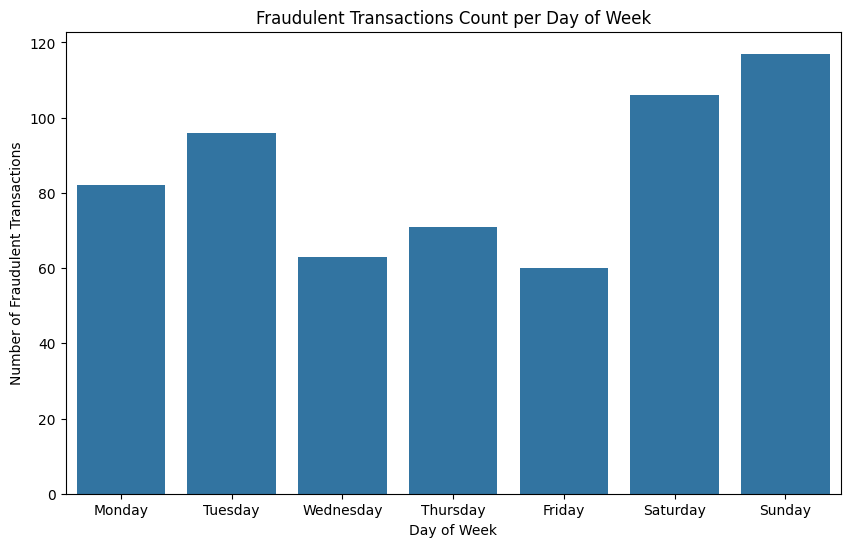

In [51]:
# Convert step → day and hour
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['hour'] = (df['step'] - 1) % 24
df['day'] = ((df['step'] - 1) // 24) % 7
df['day'] = df['day'].apply(lambda x: days_of_week[x])

# Count fraudulent transactions per day
fraud_count_by_day = df[df['is_fraud'] == 1].groupby('day').size().reindex(days_of_week)

# Bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=fraud_count_by_day.index, y=fraud_count_by_day.values)
plt.title("Fraudulent Transactions Count per Day of Week")
plt.ylabel("Number of Fraudulent Transactions")
plt.xlabel("Day of Week")
plt.show()